In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import netCDF4 as nc
import xarray as xr
from natsort import natsorted
from netCDF4 import num2date
import cmocean as cmo
import seawater as sw

In [2]:
### Loading geostrophic velocity data from altimeter
Ugeo = xr.open_dataset('/home/joao/Downloads/Projeto_BS/vgeos93-19.nc')

In [3]:
#### Slicing and obtaining running-mean for a selected area

Usmean = Ugeo.sel(latitude=slice(-32, -26),longitude=slice(308,316))['ugos'].rolling(time=60,center=True,min_periods=1).mean()
Vsmean = Ugeo.sel(latitude=slice(-32, -26),longitude=slice(308,316))['vgos'].rolling(time=60,center=True,min_periods=1).mean()

In [4]:
### Obtaining the anomalies for the sliced area

Uprime = Ugeo.sel(latitude=slice(-32, -26),longitude=slice(308,316))['ugos']-Usmean
Vprime = Ugeo.sel(latitude=slice(-32,-26),longitude=slice(308,316))['vgos']-Vsmean

In [5]:
#### Running mean (60 days, centered) for the anomalies
Uprime_mean = Uprime.rolling(time=60,center=True,min_periods=1).mean()
Vprime_mean = Vprime.rolling(time=60,center=True,min_periods=1).mean()

In [6]:
### Obtaining the total velocity anomalies mean
Velprime_mean = (Uprime*Vprime).rolling(time=60,center=True,min_periods=1).mean()

In [7]:
Uprime2bar = (Uprime**2).rolling(time=60,center=True,min_periods=1).mean()
Vprime2bar = (Vprime**2).rolling(time=60,center=True,min_periods=1).mean()

In [8]:
#### Obtaining the dx and dy parameters from the grid

dataulx = Ugeo['longitude']
datauly = Ugeo['latitude']

x,y=np.meshgrid(dataulx,datauly)
delx = np.gradient(x) #*int(111*1e3)
dely = np.gradient(y) #*int(111*1e3)
dx = delx[1].mean()*int(111*1e3)
dy = dely[0].mean()*int(111*1e3)

In [9]:
### Differentiating velocities and converting from degrees to meters (units must be in S.I, always!)
### This is done by dividing the data (which varies in degrees coordinates) by 111*1e3, hence a degree of latitude is aproximatelly 111km

dUmean_dy = Usmean.differentiate('latitude')/(111*1e3)
dUmean_dx = Usmean.differentiate('longitude')/(111*1e3)

dVmean_dy = Vsmean.differentiate('latitude')/(111*1e3)
dVmean_dx = Vsmean.differentiate('longitude')/(111*1e3)

The horizontal shear production (HSP) is obtained by the following formulae:

$$
HSP = - \bar{u'^{2}}\frac{d\bar{u}}{dx} - \bar{u'v'}\frac{d\bar{u}}{dy} - \bar{v'^{2}}\frac{d\bar{v}}{dy} - \bar{u'v'}\frac{d\bar{v}}{dx}
$$

which will be solved numerically in the next cell

In [10]:
HSP = (-Uprime2bar*dUmean_dx) - (Velprime_mean*dUmean_dy) - (Vprime2bar*dVmean_dy) - (Velprime_mean*dVmean_dx)

In [11]:
HSP_m = HSP[60:-60,:,:].groupby("time.month").mean(dim=['time']) ### Obtaining monthly means of HSP
HSP_s = HSP[60:-60,:,:].groupby("time.season").mean(dim=['time']) ### Obtaining seasonal means of HSP

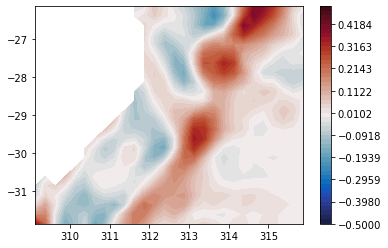

In [14]:
c=plt.contourf(HSP['longitude'],HSP['latitude'],HSP_s[2,:,:]*1e7,levels=np.linspace(-.5,.5,50),cmap=cmo.cm.balance)
plt.colorbar(c)

In [15]:
umean = Ugeo.sel(latitude=slice(-32, -26),longitude=slice(308,316))['ugos']
vmean = Ugeo.sel(latitude=slice(-32, -26),longitude=slice(308,316))['vgos']

Now we will compute the gradient of vorticity. Here, the vorticity is the sum of planetary and relative vorticity
given by:

$$
 \Pi = f + \zeta
$$

where $f$ is the planetary vorticity and $\zeta$ is the vertical component of the velocity curl: 

$$
 \zeta = \frac{dv}{dx} - \frac{du}{dy}
$$

Then, the gradient of vorticity is:

$$
    \nabla\Pi = \frac{d\Pi}{dx} + \frac{d\Pi}{dy}
$$

and this is 

In [18]:
dUmean_dy = umean.differentiate('latitude')/(111*1e3) 
dVmean_dx = vmean.differentiate('longitude')/(111*1e3)

dUmm_dy = umean.differentiate('latitude')/(111*1e3)
dVmm_dx = vmean.differentiate('longitude')/(111*1e3)

relvort = (dVmean_dx - dUmean_dy)

relvort2 = np.mean(sw.f(vmean['latitude']))+relvort

delwx = relvort2.differentiate('longitude')/(111*1e3)
delwy = relvort2.differentiate('latitude')/(111*1e3)
    
w3 = delwx+delwy
#W[i,:,:] = Sn**2+Ss**2-w**2

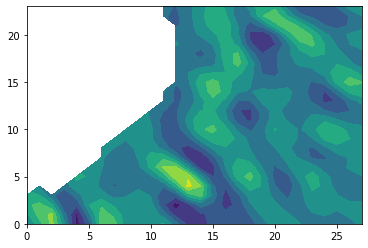

In [19]:
c=plt.contourf(w3[0,:,:])